# **Modelo Multimodal: Imagen - Texto**
## **Para la detección de defectos/características con Qwen 2.5**

https://huggingface.co/Qwen/Qwen2.5-VL-3B-Instruct

https://www.kaggle.com/datasets/yidazhang07/bridge-cracks-image

https://www.kaggle.com/datasets/ipythonx/mvtec-ad

In [ ]:
!pip install git+https://github.com/huggingface/transformers
!pip install qwen-vl-utils

  Cloning https://github.com/huggingface/transformers to /tmp/pip-req-build-c01axktq
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/transformers /tmp/pip-req-build-c01axktq
  Resolved https://github.com/huggingface/transformers to commit 0725cd6953803b8aacfc85288cbfb83dea30c469
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for transformers: filename=transformers-4.53.0.dev0-py3-none-any.whl size=11461479 sha256=c0be110e454a14bace41fe6ff91d4c1842981658151893a3b8bceb47e741c378
  Stored in directory: /tmp/pip-ephem-wheel-cache-ozs17n41/wheels/04/a3/f1/b88775f8e1665827525b19ac7590250f1038d947067beba9fb
Successfully built transformers
  Attempting uninstall: transformers
    Found existing installation: transformers 4.52.4
    Uninstalling transformers-4.52.4:
      Successfully uninstalled transformers-4.52.4
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
import json
import matplotlib.pyplot as plt
from PIL import Image
import matplotlib.patches as patches

In [ ]:
from PIL import Image
import requests

In [ ]:
from transformers import Qwen2_5_VLForConditionalGeneration, AutoTokenizer, AutoProcessor
from qwen_vl_utils import process_vision_info

In [ ]:
# cargamos el modelo - dependiendo de la tarea requerirías GPU:
model = Qwen2_5_VLForConditionalGeneration.from_pretrained(
    "Qwen/Qwen2.5-VL-3B-Instruct",
    torch_dtype="auto",
    device_map="auto"
)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/1.37k [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/65.4k [00:00<?, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/3.53G [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/3.98G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/216 [00:00<?, ?B/s]

In [ ]:
# Determina el tamaño de los tokens-visuales:

min_pixels = 256*28*28
max_pixels = 1280*28*28

processor = AutoProcessor.from_pretrained("Qwen/Qwen2.5-VL-3B-Instruct",
                                          min_pixels=min_pixels,
                                          max_pixels=max_pixels
                                          )

preprocessor_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


tokenizer_config.json:   0%|          | 0.00/5.70k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/2.78M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/1.67M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/7.03M [00:00<?, ?B/s]

You have video processor config saved in `preprocessor.json` file which is deprecated. Video processor configs should be saved in their own `video_preprocessor.json` file. You can rename the file or load and save the processor back which renames it automatically. Loading from `preprocessor.json` will be removed in v5.0.


chat_template.json:   0%|          | 0.00/1.05k [00:00<?, ?B/s]

In [ ]:
# Caso Zero-Shot:
def zero_shot_inference(model, processor, image, prompt):
  messages = [
      {
          "role": "user",
          "content": [
              {
                  "type": "image",
                  "image": image,
              },
              {"type": "text", "text": prompt},
          ],
      }
  ]

  # Definiendo características de la inferencia:
  text = processor.apply_chat_template(
      messages, tokenize=False, add_generation_prompt=True
  )
  image_inputs, video_inputs = process_vision_info(messages)
  inputs = processor(
      text=[text],
      images=image_inputs,
      videos=video_inputs,
      padding=True,
      return_tensors="pt",
  )
  inputs = inputs.to("cuda")

  # Salida:
  generated_ids = model.generate(**inputs, max_new_tokens=1024)
  generated_ids_trimmed = [
      out_ids[len(in_ids) :] for in_ids, out_ids in zip(inputs.input_ids, generated_ids)
  ]
  output_text = processor.batch_decode(
      generated_ids_trimmed, do_sample=True, skip_special_tokens=True, clean_up_tokenization_spaces=False
  )[0]
  input_height = inputs['image_grid_thw'][0][1]*14
  input_width = inputs['image_grid_thw'][0][2]*14

  return output_text, input_height, input_width

In [ ]:
def plot_bounding_boxes(image, json_data, height, width):
  image = image.resize((width, height))

  # entrada en formato json:
  json_data = json_data.split('```json')[1].split('```')[0]
  bbox_data = json.loads(json_data)

  # graficando:
  fig, ax = plt.subplots(1)
  ax.imshow(image)
  ax.axis('off')

  # Graficando el rectángulo y el texto:
  for item in bbox_data:
      bbox = item['bbox_2d']
      label = item['label']
      rect = patches.Rectangle((bbox[0], bbox[1]), bbox[2] - bbox[0], bbox[3] - bbox[1], linewidth=2, edgecolor='r', facecolor='none')
      ax.add_patch(rect)
      plt.text(bbox[0], bbox[1] - 10, label, color='r', fontsize=10)
  plt.show()

In [ ]:
prompt = """
Detecta todos los objetos en la imagen y devuelve sus
localizaciones y etiquetas (coche, camión, autobús, motocicleta, bicicleta, persona) en el formato de coordenadas.
"""

```json
[
	{"bbox_2d": [304, 150, 367, 213], "label": "coche"},
	{"bbox_2d": [404, 128, 449, 178], "label": "camión"},
	{"bbox_2d": [448, 0, 560, 305], "label": "camión"},
	{"bbox_2d": [245, 128, 318, 258], "label": "motocicleta"},
	{"bbox_2d": [130, 92, 250, 332], "label": "motocicleta"},
	{"bbox_2d": [224, 136, 248, 160], "label": "camión"},
	{"bbox_2d": [357, 147, 376, 178], "label": "camión"},
	{"bbox_2d": [130, 92, 250, 332], "label": "persona"}
]
```


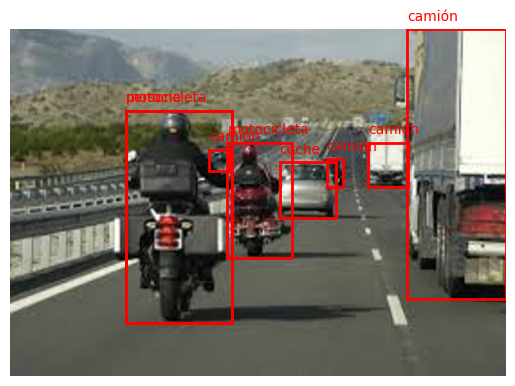

In [ ]:
image = Image.open("00c1.jpg")

response, height, width = zero_shot_inference(model, processor, image, prompt)

print(response)

plot_bounding_boxes(image, response, height, width)

```json
[
	{"bbox_2d": [610, 475, 783, 690], "label": "defecto"}
]
```


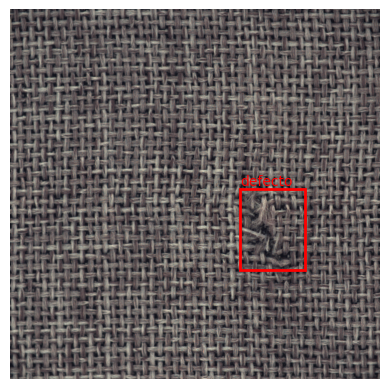

In [ ]:
prompt = """
Detecta todos los defectos en el pedazo de tela de tejido y devuelve sus
localizaciones y etiquetas (defecto) en el formato de coordenadas. Si no hay defectos,
devuelve una etiqueta de no-defecto.
"""

image = Image.open("001.png")
#image = Image.open("005.png")

response, height, width = zero_shot_inference(model, processor, image, prompt)

print(response)

plot_bounding_boxes(image, response, height, width)

```json
[
	{"bbox_2d": [347, 91, 640, 835], "label": "defecto"}
]
```


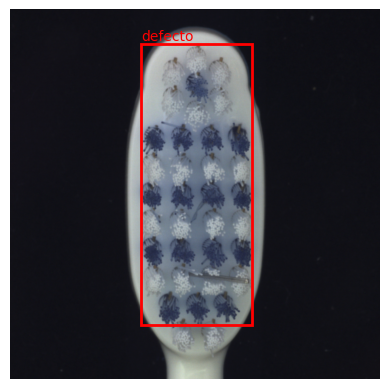

In [ ]:
prompt = """
Detecta todos los defectos entre las cerdas del cepillo de dientes y devuelve sus
localizaciones y etiquetas (defecto) en el formato de coordenadas. Si no hay defectos,
devuelve una etiqueta de no-defecto.
"""

#image = Image.open("002.png")
image = Image.open("004.png")

response, height, width = zero_shot_inference(model, processor, image, prompt)

print(response)

plot_bounding_boxes(image, response, height, width)

```json
[
	{"bbox_2d": [495, 378, 1046, 589], "label": "coche no respetando el área peatonal"}
]
```


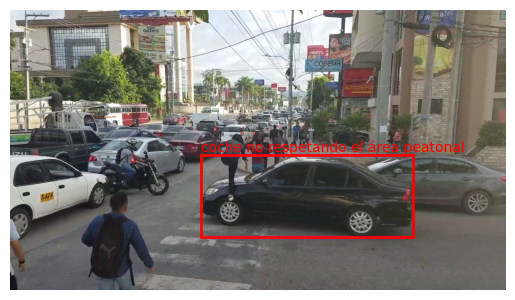

In [ ]:
prompt = "Detecta el coche que no está respetando el área peatonal. Y devuelve sus localizaciones y etiquetas (multa) en el formato de coordenadas. "

image = Image.open("0022.jpg")

response, height, width = zero_shot_inference(model, processor, image, prompt)

print(response)
plot_bounding_boxes(image, response, height, width)

```json
[
	{"bbox_2d": [36, 57, 448, 587], "label": "persona que está golpeando"}
]
```


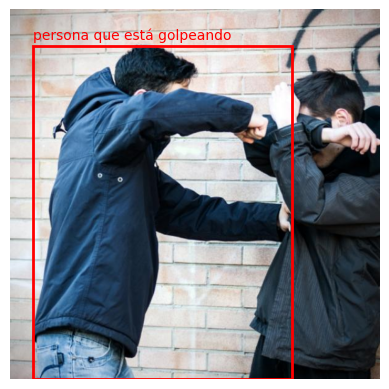

In [ ]:
prompt = "Identifica a las persona que está golpeando. Y devuelve sus localizaciones y etiquetas (cubre) en el formato de coordenadas. "

image = Image.open("0033.jpg")

response, height, width = zero_shot_inference(model, processor, image, prompt)

print(response)
plot_bounding_boxes(image, response, height, width)